<a href="https://colab.research.google.com/github/Kalva014/HairHub/blob/main/colab_notebooks/Hair_Detection_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install transformers
!pip install torch
!pip install pandas

# Create Labeled Dataset

In [44]:
# Import libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [49]:
# Load the Input Images
inital_img_dir = '/content/drive/MyDrive/Hairhub_data/initial_images'
img_dataset = glob.glob(os.path.join(inital_img_dir, "*/*.jpg"))

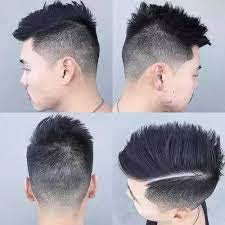

In [53]:
# Show the first image
img = Image.open(img_dataset[0])
img

In [55]:
# Load the labels of the input images(aka the masks)
labels_dir = '/content/drive/MyDrive/Hairhub_data/segmented_imgs'
labels_dataset = glob.glob(os.path.join(labels_dir, "*/*.csv"))

In [65]:
# Show the first mask
label_data = np.loadtxt(labels_dataset[0])
label_data.shape
# plt.imshow(label_data.reshape(584,565,3))
# img = Image.open(labels_dataset[0])
# img

(4080, 3)

In [39]:
x = np.copy(roi_pixels)
print(x.shape)
for index in range(1, len(csv_files)):
        pixels_to_concat = np.loadtxt(csv_files[index])
        print(pixels_to_concat.shape)
        # x = np.concatenate((x, pixels_to_concat))
        print(x.shape)
        break

(1, 4080, 3)
(1427, 3)
(1, 4080, 3)


# Preprocess The Dataset

# Create The Model

# Train The Model

# Save The Model

# Evaluate the Model